## Hotel Review

We aim to perform sentiment analysis on customer reviews to understand their 
sentiments towards a product or service. This helps us to understand customer 
satisfaction and areas that need improvement.
 
NLP Techniques: 
1. Text Preprocessing: Tokenization, stop word removal and lemmatization. 
2. Feature Extraction: Bag of Words, Term Frequency – Inverse Document 
Frequency (TF-IDF) and word embeddings. 
3. Sentiment Classification: Random Forest (RF) Classifier, Logistic Regression, 
CNN 

### Data Preparation

Each customer review is a textual feedback and an overall rating.  
The ratings can range from 1 to 10.  
We will split them into two categories: bad reviews have ratings < 5 and good reviews have ratings >= 5.

The textual is divide into two part (positive and negative). We group the together in order to start with only one raw text data.
additionally if the user doesn't leave any negative or positive comment, this will appear as "No Negative" or "No Positive". those part have to be removed from the text.

In [1]:
import pandas as pd

#read data
reviews = pd.read_pickle('dataset/Hotel_Reviews.pkl')

#append the positive and negative reviews
reviews['review'] = reviews['Negative_Review'] + reviews['Positive_Review']
#create the label
reviews['review_type'] = reviews['Reviewer_Score'].apply(lambda x: 'Bad_review' if x < 5 else 'Good_review')
#sample data in order to speed up the computation
reviews = reviews.sample(frac=0.1, replace=False, random_state=42)
#clean data
reviews['review'] = reviews['review'].apply(lambda x: x.replace('No Negative', '').replace('No Positive', '')) 


### Data cleaning

We will perform several transformations to clean the textual data:
- tokenize the text and remove the punctuation
- remove useless stop words
- lemmatize the text

In [2]:
#lemmatize token and remove stop word, if len of word is greater than 1 remove it 
from typing import List
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clean_text(text: str) -> List[str]:
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and len(token) > 1]

reviews['review_clean'] = reviews['review'].apply(lambda x: clean_text(x))

### tfidf Encoding

We want to create document embeddings using bag-of-words approach 

In [3]:
from typing import List
from scipy.sparse import lil_matrix
import numpy as np

class TfIdfModel:

    def __init__(self):
        self.index = dict()
        self.precomputed_embeddings = dict()
        
    #Create an index for the vocabulary from the docs

    def build_index(self, docs: List[List[str]]) -> None:
        words = [word for doc in docs for word in doc]
        self.index = {word:i for i, word in enumerate(sorted(set(words)))}


    def train(self, docs: List[List[str]]) -> None:
        self.build_index(docs)
        num_docs = len(docs)
        num_terms = len(self.index)
    
        # Use a sparse matrix
        term_doc_matrix = lil_matrix((num_docs, num_terms), dtype=np.float64)
    
        # Compute the term frequency matrix
        for i, doc in enumerate(docs):
            for term in doc:
                term_doc_matrix[i, self.index[term]] += 1
    
        # Convert to CSR format for efficient arithmetic operations
        term_doc_matrix = term_doc_matrix.tocsr()
    
        td_log_matrix = term_doc_matrix.copy()
        td_log_matrix.data = np.log10(td_log_matrix.data + 1)
    
        df_vector = np.diff(term_doc_matrix.tocsc().indptr)
        df_vector[df_vector == 0] = 1
        idf_vector = np.log10(num_docs / df_vector)
    
        self.tfidf_matrix = td_log_matrix.multiply(idf_vector)

        for term, idx in self.index.items():
            self.precomputed_embeddings[term] = self.tfidf_matrix.getcol(idx).toarray().flatten()

    def embed(self, word: str) -> np.ndarray:
        return self.precomputed_embeddings.get(word, None)

    def vector_size(self) -> int:
        return self.tfidf_matrix.shape[0]
    

### Bag of Words
Create a document embedding using the bag of words approach

In [4]:
def bagOfWords(model: TfIdfModel, doc: List[str]) -> np.ndarray:
    embeds = [model.embed(token) for token in doc if token in model.precomputed_embeddings]
    
    if embeds:
        embeds = np.array(embeds)
        return embeds.mean(axis=0)
    
    return np.zeros(model.vector_size())


In [5]:
model = TfIdfModel()  
model.train(reviews['review_clean'].tolist())

embed_train = np.array([bagOfWords(model, review) for review in reviews['review_clean']])
labels_train = np.array([round(score) for score in reviews['Reviewer_Score']])

print(embed_train.shape)
print(labels_train.shape)


(20000, 20000)
(20000,)


### plot the confusion matrix and calculate f1_score

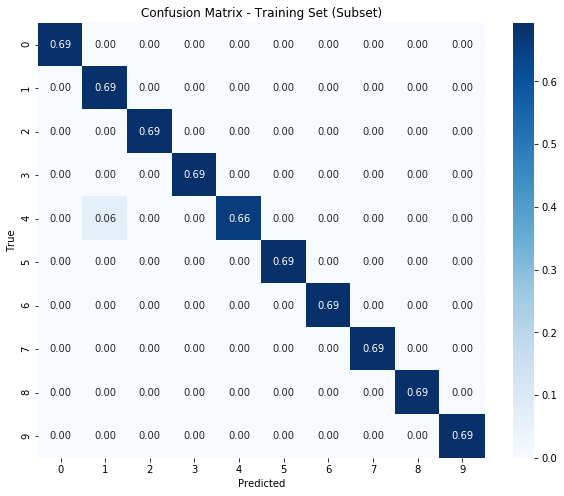

F1 Score - Training Set (Subset): 0.9948979591836735
Wall time: 43.6 s


In [15]:
%%time
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# sample data
np.random.seed(0)
embed_train = np.random.rand(20000, 20000)
labels_train = np.random.randint(0, 1000, 20000)

# Dimensionality reduction using PCA
pca = PCA(n_components=200)
embed_train_reduced = pca.fit_transform(embed_train)

unique_classes = np.unique(labels_train)[:10]
mask = np.isin(labels_train, unique_classes)

embed_train_subset = embed_train_reduced[mask]
labels_train_subset = labels_train[mask]

label_encoder = LabelEncoder()
labels_train_subset_encoded = label_encoder.fit_transform(labels_train_subset)

classifier = SVC(kernel='poly')
classifier.fit(embed_train_subset, labels_train_subset_encoded)

train_predict_subset = classifier.predict(embed_train_subset)
cm = confusion_matrix(labels_train_subset_encoded, train_predict_subset, normalize='true')

# Use a heatmap with a logarithmic scale to better visualize the data
plt.figure(figsize=(10, 8))
sns.heatmap(np.log1p(cm), annot=True, fmt=".2f", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Training Set (Subset)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


f1_score_train_subset = f1_score(labels_train_subset_encoded, train_predict_subset, average='micro')
print("F1 Score - Training Set (Subset):", f1_score_train_subset)
